In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import scanpy as sc
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pytorch_lightning as pl
import scipy
import random
import scgpt as scg
from pathlib import Path
import sklearn


/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# read data

In [3]:
adata_full = sc.read_h5ad("/data/rna_rep_learning/luca_salcher2022/luca_w_scGPT_embeds.h5ad")

In [10]:
adata_full

# task 1: predict biopsy site: primary vs metastatic, based on tumor cells alone

## define sample pool, target, X, splits for this task

### define sample_pool for this target

In [75]:
#filter adata to just tumor cells
adata = adata_full

In [76]:
sample_col = 'sample'
target_col = 'origin'

In [77]:
adata.obs[[sample_col, target_col]].drop_duplicates()[target_col].value_counts()

origin
tumor_primary       254
normal_adjacent     137
normal              109
tumor_metastasis     54
nan                   2
Name: count, dtype: int64

/tmp/ipykernel_4043237/829841891.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  luca_malig_filter = pd.DataFrame(adata.obs.groupby(["origin",sample_col]).cell_type.value_counts()).rename(columns={'count':'cell_type_counts'})


(array([18., 15., 12.,  8.,  7.,  7.,  6.,  2.,  2.,  2., 10.,  5.,  4.,
         2.,  7.,  1.,  3.,  5.,  4.,  3.]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ,
        54.9, 59.8, 64.7, 69.6, 74.5, 79.4, 84.3, 89.2, 94.1, 99. ]),
 <BarContainer object of 20 artists>)

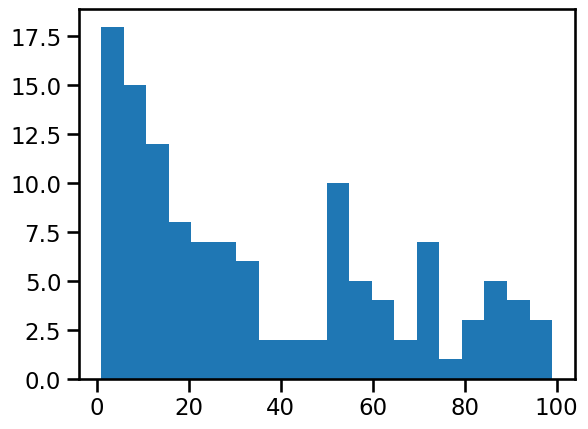

In [78]:
#only keep samples that have >=n tumor cells. histogram of n tumor cells per sample, for samples with 0 > n < 100 cells. To help decide on cutoff
luca_malig_filter = pd.DataFrame(adata.obs.groupby(["origin",sample_col]).cell_type.value_counts()).rename(columns={'count':'cell_type_counts'})
luca_malig_filter = luca_malig_filter.reset_index()
luca_malig_filter = luca_malig_filter[((luca_malig_filter.origin=="tumor_primary") | (luca_malig_filter.origin=="tumor_metastasis")) & (luca_malig_filter.cell_type=="malignant cell") & (luca_malig_filter.cell_type_counts !=0)]

plt.hist(luca_malig_filter[luca_malig_filter.cell_type_counts<=100].cell_type_counts, bins=20)

In [79]:
luca_malig_filter.index = luca_malig_filter[sample_col]

tumor_cell_samples = luca_malig_filter[luca_malig_filter.cell_type_counts >=15][sample_col]

In [80]:
len(tumor_cell_samples)

206

In [81]:
#get sample IDs that are not NA for this target
notNA_samples = adata.obs[[sample_col,target_col]].drop_duplicates()[sample_col][adata.obs[[sample_col,target_col]].drop_duplicates()[target_col]!="nan"]
print("this target has {} non-NA samples".format(len(notNA_samples)))

this target has 554 non-NA samples


In [82]:
sample_pool = np.intersect1d(tumor_cell_samples, notNA_samples)
print(len(sample_pool))

206


In [85]:
# create a balanced dataset
counts_total_sample_pool = adata.obs.loc[adata.obs[sample_col].isin(sample_pool),[target_col,sample_col]].drop_duplicates()[target_col].astype("string").value_counts()
sample_pool = adata.obs.loc[(adata.obs[sample_col].isin(sample_pool)),[sample_col, target_col]].astype("string").drop_duplicates().groupby(target_col).sample(n=np.min(counts_total_sample_pool))["sample"]
print(len(sample_pool))

72


### define target, and limit/order by sample_pool

In [86]:
## Define targets
targets = adata.obs.loc[:, [sample_col, target_col]].drop_duplicates().set_index(sample_col).loc[sample_pool,target_col]
labels, targets_ind = np.unique(targets, return_inverse=True)
targets = pd.Series(targets_ind, index=targets.index)

In [87]:
labels

array(['tumor_metastasis', 'tumor_primary'], dtype=object)

In [88]:
targets.value_counts()/len(targets)

0    0.5
1    0.5
Name: count, dtype: float64

### splits for grouped (by dataset) 10 fold cross validation (cv outer loop)

In [89]:
from sklearn.model_selection import GroupKFold
group_kfold = GroupKFold(n_splits=10)
groups = adata.obs.set_index(sample_col).loc[sample_pool, 'dataset'].reset_index().drop_duplicates().dataset
splits = list(group_kfold.split(sample_pool, groups=groups)) #if don't convert to list, iterator is exhausted after one use


In [90]:
for (train_index, test_index) in splits:
    print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))
    print("n samples in train: ", len(train_index))
    print("n samples in test: ", len(test_index))
    print("\n")

/tmp/ipykernel_4043237/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))
/tmp/ipykernel_4043237/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))


datasets reserved for test fold:  ['Kim_Lee_2020']
n samples in train:  50
n samples in test:  22


datasets reserved for test fold:  ['Maynard_Bivona_2020']
n samples in train:  55
n samples in test:  17


datasets reserved for test fold:  ['Wu_Zhou_2021']
n samples in train:  66
n samples in test:  6




/tmp/ipykernel_4043237/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))
/tmp/ipykernel_4043237/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))
/tmp/ipykernel_4043237/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as la

datasets reserved for test fold:  ['Zilionis_Klein_2019']
n samples in train:  68
n samples in test:  4


datasets reserved for test fold:  ['Leader_Merad_2021_10x_3p_v2_digest-deadcell_cite']
n samples in train:  68
n samples in test:  4


datasets reserved for test fold:  ['Laughney_Massague_2020']
n samples in train:  68
n samples in test:  4




/tmp/ipykernel_4043237/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))
/tmp/ipykernel_4043237/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))
/tmp/ipykernel_4043237/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as la

datasets reserved for test fold:  ['Leader_Merad_2021_10x_3p_v2_beads', 'Lambrechts_Thienpont_2018_6149v2']
n samples in train:  68
n samples in test:  4


datasets reserved for test fold:  ['UKIM-V-2', 'Goveia_Carmeliet_2020']
n samples in train:  68
n samples in test:  4


datasets reserved for test fold:  ['UKIM-V', 'Lambrechts_Thienpont_2018_6149v1', 'Chen_Zhang_2020']
n samples in train:  68
n samples in test:  4


datasets reserved for test fold:  ['Lambrechts_Thienpont_2018_6653', 'He_Fan_2021']
n samples in train:  69
n samples in test:  3




/tmp/ipykernel_4043237/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))
/tmp/ipykernel_4043237/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))


## create pseudobulk embeddings to use downstream

In [91]:
adata = adata[(adata.obs[sample_col].isin(sample_pool)) & (adata.obs.cell_type=="malignant cell")]
adata

View of AnnData object with n_obs × n_vars = 28394 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_c

In [92]:
adata.obs[sample_col].drop_duplicates().size

72

In [93]:
adata.obs.cell_type.value_counts()

cell_type
malignant cell    28394
Name: count, dtype: int64

In [94]:
pbulk_embs = {}

#### scGPT

In [95]:
emb_name = 'X_scGPT'

## Input
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

#limit to the sample pool, this will also put it in the right order to index using the groupkfold inds
pbulk_embs[emb_name] = pseudobulk_input#.loc[sample_pool,:]

/tmp/ipykernel_4043237/2538767356.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()


#### scGPT -> 40 PCs

In [96]:
emb_name = 'X_scGPT'

pca = sklearn.decomposition.PCA(n_components=40)
scgpt_input_pca = pca.fit_transform(adata.obsm[emb_name])

## Input
pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

#limit to the sample pool, this will also put it in the right order to index using the groupkfold inds
pbulk_embs['scgpt_40PCs'] = pseudobulk_input#.loc[sample_pool,:]

/tmp/ipykernel_4043237/2718990846.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()


#### scANVI

In [97]:
emb_name = 'X_scANVI'

## Input
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

#limit to the sample pool, this will also put it in the right order to index using the groupkfold inds
pbulk_embs[emb_name] = pseudobulk_input#.loc[sample_pool,:]

/tmp/ipykernel_4043237/967565294.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()


#### cell type props

In [98]:
## Input
celltype_counts_df = pd.DataFrame(adata.obs.groupby(sample_col).cell_type.value_counts()).rename({'count':'cell_type_counts'},axis=1).reset_index().pivot(index=sample_col, columns="cell_type", values="cell_type_counts")
celltype_fracs_df = celltype_counts_df.div(celltype_counts_df.sum(axis=1), axis=0)
pseudobulk_input = celltype_fracs_df
pbulk_embs['ct_props'] = pseudobulk_input#.loc[sample_pool,:]

/tmp/ipykernel_4043237/540146638.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  celltype_counts_df = pd.DataFrame(adata.obs.groupby(sample_col).cell_type.value_counts()).rename({'count':'cell_type_counts'},axis=1).reset_index().pivot(index=sample_col, columns="cell_type", values="cell_type_counts")


#### cell type props + mean embedding based on scGPT

In [99]:
#get mean embedding per cell type

emb_name = 'X_scGPT'

# get mean embedding per sample+cell_type
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()

# change columns to more interpretable strs 
pseudobulk_input.columns = ['scgpt_'+str(c) for c in pseudobulk_input.columns]

# cell types that dont exist in a given sample - fill 0 for mean expression
pseudobulk_input = pseudobulk_input.fillna(0).reset_index()

# Pivot the dataframe
psblk_per_celltype = pseudobulk_input.pivot(index=sample_col, columns='cell_type')

# Flatten the multi-level columns
psblk_per_celltype.columns = ['_'.join(col).strip() for col in psblk_per_celltype.columns.values]

/tmp/ipykernel_4043237/3601337964.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()


In [100]:
# concat cell type fracs and mean embs dfs
pbulk_embs['ct_fracs_means_scGPTfull'] = pbulk_embs['ct_props'].merge(psblk_per_celltype, right_index=True, left_index=True)

#### cell type props + mean embedding based on scGPT+40PCs

In [101]:
#get mean embedding per cell type

emb_name = 'X_scGPT'
pca = sklearn.decomposition.PCA(n_components=40)
scgpt_input_pca = pca.fit_transform(adata.obsm[emb_name])

# get mean embedding per sample+cell_type
pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()

# change columns to more interpretable strs 
pseudobulk_input.columns = ['scgpt_'+str(c) for c in pseudobulk_input.columns]

# cell types that dont exist in a given sample - fill 0 for mean expression
pseudobulk_input = pseudobulk_input.fillna(0).reset_index()

# Pivot the dataframe
psblk_per_celltype = pseudobulk_input.pivot(index=sample_col, columns='cell_type')

# Flatten the multi-level columns
psblk_per_celltype.columns = ['_'.join(col).strip() for col in psblk_per_celltype.columns.values]

/tmp/ipykernel_4043237/125621020.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()


In [102]:
# concat cell type fracs and mean embs dfs
pbulk_embs['ct_fracs_means_scGPT_40PCs'] = pbulk_embs['ct_props'].merge(psblk_per_celltype, right_index=True, left_index=True)

#### cell type props + mean embedding based on scANVI

In [103]:
#get mean embedding per cell type

emb_name = 'X_scANVI'

# get mean embedding per sample+cell_type
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()

# change columns to more interpretable strs 
pseudobulk_input.columns = ['scanvi_'+str(c) for c in pseudobulk_input.columns]

# cell types that dont exist in a given sample - fill 0 for mean expression
pseudobulk_input = pseudobulk_input.fillna(0).reset_index()

# Pivot the dataframe
psblk_per_celltype = pseudobulk_input.pivot(index=sample_col, columns='cell_type')

# Flatten the multi-level columns
psblk_per_celltype.columns = ['_'.join(col).strip() for col in psblk_per_celltype.columns.values]

/tmp/ipykernel_4043237/2841900010.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()


In [104]:
# concat cell type fracs and mean embs dfs
pbulk_embs['ct_fracs_means_scANVI'] = pbulk_embs['ct_props'].merge(psblk_per_celltype, right_index=True, left_index=True)

### limit/order pseudobulk embeddings by sample_pool

In [105]:
this_pbulk_embs = {}
for emb in pbulk_embs:
    this_pbulk_embs[emb] = pbulk_embs[emb].loc[sample_pool]

## calculate heuristic baseline performance on these splits

not including majority class per study as a baseline, since we shouldn't have study based batch effects affecting performance using our GroupKFold!

In [106]:
val_majclass_bline_accs= []

for (train_index, val_index) in splits:
    #calculate baseline performance - majority class
    majclass_bline_pred = targets.iloc[train_index].value_counts().index[targets.iloc[train_index].value_counts().argmax()]
    if majclass_bline_pred not in targets.iloc[val_index].value_counts().index:
        val_majclass_bline_accs.append(0)
    else:
        val_majclass_bline_accs.append(targets.iloc[val_index].value_counts()[majclass_bline_pred]/len(val_index))

print("baseline accuracy on K val sets: ", np.around(val_majclass_bline_accs,3))
print("mean accuracy: ", np.round(np.mean(val_majclass_bline_accs),3))

baseline accuracy on K val sets:  [0.136 0.235 0.    0.    0.    0.    0.    0.    0.    0.   ]
mean accuracy:  0.037


## Evaluate models using nested GroupKFold CV

In [107]:
## train KNN w/ Kfold CV
from sklearn.model_selection import GridSearchCV, cross_val_score

def nested_kfold_eval(pseudobulk_input, targets, splits, model, param_grid):

    # Inner CV for hyperparameter tuning
    inner_cv = GridSearchCV(model, param_grid, cv=5)

    # Nested CV
    nested_score = cross_val_score(inner_cv, pseudobulk_input, targets, cv=group_kfold, groups=groups)
    
    print("Nested CV Score: ", np.round(nested_score.mean(),3))
    
    return nested_score

In [108]:
# set up a dict with models and hparams to test

model_param_dict = {
    'KNN': (KNeighborsClassifier(), {'n_neighbors':np.arange(10)+1}),
    'random_forest' : (RandomForestClassifier(), {'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}),
    'logistic_regression': (LogisticRegression(max_iter=500), {'C':[1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]})
}


In [112]:
task1_results = {}
for model in model_param_dict:
    print("--------- {} ----------".format(model))
    task1_results[model] = {}
    for emb in ['X_scGPT', 'scgpt_40PCs', 'X_scANVI']: #our proxies arent meaningful when there is only one cell type
        print('embedding: ', emb)
        print('shape of embedding: ', this_pbulk_embs[emb].shape)
        task1_results[model][emb] = nested_kfold_eval(this_pbulk_embs[emb], targets, splits, model=model_param_dict[model][0], param_grid = model_param_dict[model][1])
        print("\n")
    print("\n")

--------- logistic_regression ----------
embedding:  X_scGPT
shape of embedding:  (72, 512)
Nested CV Score:  0.537


embedding:  scgpt_40PCs
shape of embedding:  (72, 40)
Nested CV Score:  0.557


embedding:  X_scANVI
shape of embedding:  (72, 10)
Nested CV Score:  0.037






## TO DO - significance testing, not most important for getting high level sense of where the signal is

In [ ]:
# check significance of promising results

# need to record per-sample predictions and then FOR SAMPLES where models disagree, can run either binomial or wilcoxon signed-rank test


# task 2a: predict stage, early vs advanced - only include lung biopsies (pretty hard problem), all cells

## define sample pool, target, X, splits for this task

### define sample_pool for this target

In [4]:
#filter adata to just tumor cells
adata = adata_full

In [5]:
sample_col = 'sample'
target_col = 'tumor_stage'

In [6]:
adata.obs[[sample_col, target_col]].drop_duplicates()[target_col].value_counts(dropna=False)

tumor_stage
early         262
advanced      173
non-cancer    120
NaN             1
Name: count, dtype: int64

In [7]:
#get sample IDs that are not NA for this target
notNA_samples = adata.obs[[sample_col,target_col]].drop_duplicates()[sample_col][~adata.obs[[sample_col,target_col]].drop_duplicates()[target_col].isna()]
print("this target has {} non-NA samples".format(len(notNA_samples)))

this target has 555 non-NA samples


In [8]:
# dont include non-cancer samples
cancer_samples = adata.obs.loc[adata.obs.tumor_stage!="non-cancer",sample_col].drop_duplicates()

In [9]:
# only include lung samples
lung_samples = adata.obs.loc[adata.obs.tissue=="lung",sample_col].drop_duplicates()

In [10]:
sample_pool = np.intersect1d(np.intersect1d(cancer_samples, notNA_samples), lung_samples)
print(len(sample_pool))

376


In [11]:
# create a balanced dataset
counts_total_sample_pool = adata.obs.loc[adata.obs[sample_col].isin(sample_pool),[target_col,sample_col]].drop_duplicates()[target_col].astype("string").value_counts()
print(counts_total_sample_pool)

sample_pool = adata.obs.loc[(adata.obs[sample_col].isin(sample_pool)),[sample_col, target_col]].astype("string").drop_duplicates().groupby(target_col).sample(n=np.min(counts_total_sample_pool))["sample"]
print("\ndataset size after sampling to balance classes: ", len(sample_pool))


tumor_stage
early       249
advanced    127
Name: count, dtype: Int64

dataset size after sampling to balance classes:  254


#### save an anndata object that only contains sample_pool to pass into scSet

In [12]:
adata[adata.obs[sample_col].isin(sample_pool),:].write("/data/rna_rep_learning/luca_salcher2022/luca_salcher2022_SAMPLEPOOL_lungonly_earlyvsadvanced_n254.h5ad")

### define target, and limit/order by sample_pool

In [137]:
## Define targets
targets = adata.obs.loc[:, [sample_col, target_col]].drop_duplicates().set_index(sample_col).loc[sample_pool,target_col]
labels, targets_ind = np.unique(targets, return_inverse=True)
targets = pd.Series(targets_ind, index=targets.index)

In [138]:
labels

array(['advanced', 'early'], dtype=object)

In [139]:
targets.value_counts()/len(targets)

0    0.5
1    0.5
Name: count, dtype: float64

### splits for grouped (by dataset) 10 fold cross validation (cv outer loop)

In [140]:
from sklearn.model_selection import GroupKFold
group_kfold = GroupKFold(n_splits=10)
groups = adata.obs.set_index(sample_col).loc[sample_pool, 'dataset'].reset_index().drop_duplicates().dataset
splits = list(group_kfold.split(sample_pool, groups=groups)) #if don't convert to list, iterator is exhausted after one use


In [141]:
for (train_index, test_index) in splits:
    print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))
    print("n samples in train: ", len(train_index))
    print("n samples in test: ", len(test_index))
    print("\n")

/tmp/ipykernel_4043237/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))
/tmp/ipykernel_4043237/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))


datasets reserved for test fold:  ['Wu_Zhou_2021']
n samples in train:  212
n samples in test:  42


datasets reserved for test fold:  ['Guo_Zhang_2018']
n samples in train:  213
n samples in test:  41




/tmp/ipykernel_4043237/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))
/tmp/ipykernel_4043237/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))


datasets reserved for test fold:  ['Leader_Merad_2021_10x_3p_v2_beads']
n samples in train:  231
n samples in test:  23


datasets reserved for test fold:  ['UKIM-V-2']
n samples in train:  232
n samples in test:  22




/tmp/ipykernel_4043237/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))
/tmp/ipykernel_4043237/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))


datasets reserved for test fold:  ['Kim_Lee_2020', 'Leader_Merad_2021_10x_5p_v1_beads', 'Leader_Merad_2021_10x_3p_v3_beads']
n samples in train:  232
n samples in test:  22


datasets reserved for test fold:  ['Maynard_Bivona_2020', 'Leader_Merad_2021_10x_3p_v1_sort', 'Goveia_Carmeliet_2020']
n samples in train:  233
n samples in test:  21




/tmp/ipykernel_4043237/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))
/tmp/ipykernel_4043237/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))


datasets reserved for test fold:  ['Zilionis_Klein_2019', 'Leader_Merad_2021_10x_3p_v2_sort', 'He_Fan_2021']
n samples in train:  233
n samples in test:  21


datasets reserved for test fold:  ['Lambrechts_Thienpont_2018_6653', 'Leader_Merad_2021_10x_5p_v1_CD2', 'Leader_Merad_2021_10x_3p_v2_digest-deadcell_cite']
n samples in train:  234
n samples in test:  20




/tmp/ipykernel_4043237/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))
/tmp/ipykernel_4043237/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))


datasets reserved for test fold:  ['Lambrechts_Thienpont_2018_6149v2', 'Lambrechts_Thienpont_2018_6149v1', 'Leader_Merad_2021_10x_3p_v2_beads_cite']
n samples in train:  233
n samples in test:  21


datasets reserved for test fold:  ['Laughney_Massague_2020', 'Chen_Zhang_2020', 'UKIM-V']
n samples in train:  233
n samples in test:  21




## create pseudobulk embeddings to use downstream

In [142]:
pbulk_embs = {}

#### scGPT

In [143]:
emb_name = 'X_scGPT'

## Input
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

#limit to the sample pool, this will also put it in the right order to index using the groupkfold inds
pbulk_embs[emb_name] = pseudobulk_input#.loc[sample_pool,:]

/tmp/ipykernel_4043237/2538767356.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()


#### scGPT -> 40 PCs

In [144]:
emb_name = 'X_scGPT'

pca = sklearn.decomposition.PCA(n_components=40)
scgpt_input_pca = pca.fit_transform(adata.obsm[emb_name])

## Input
pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

#limit to the sample pool, this will also put it in the right order to index using the groupkfold inds
pbulk_embs['scgpt_40PCs'] = pseudobulk_input#.loc[sample_pool,:]

/tmp/ipykernel_4043237/2718990846.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()


#### scANVI

In [145]:
emb_name = 'X_scANVI'

## Input
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

#limit to the sample pool, this will also put it in the right order to index using the groupkfold inds
pbulk_embs[emb_name] = pseudobulk_input#.loc[sample_pool,:]

/tmp/ipykernel_4043237/967565294.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()


#### cell type props

In [146]:
## Input
celltype_counts_df = pd.DataFrame(adata.obs.groupby(sample_col).cell_type.value_counts()).rename({'count':'cell_type_counts'},axis=1).reset_index().pivot(index=sample_col, columns="cell_type", values="cell_type_counts")
celltype_fracs_df = celltype_counts_df.div(celltype_counts_df.sum(axis=1), axis=0)
pseudobulk_input = celltype_fracs_df
pbulk_embs['ct_props'] = pseudobulk_input#.loc[sample_pool,:]

/tmp/ipykernel_4043237/540146638.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  celltype_counts_df = pd.DataFrame(adata.obs.groupby(sample_col).cell_type.value_counts()).rename({'count':'cell_type_counts'},axis=1).reset_index().pivot(index=sample_col, columns="cell_type", values="cell_type_counts")


#### cell type props + mean embedding based on scGPT

In [147]:
#get mean embedding per cell type

emb_name = 'X_scGPT'

# get mean embedding per sample+cell_type
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()

# change columns to more interpretable strs 
pseudobulk_input.columns = ['scgpt_'+str(c) for c in pseudobulk_input.columns]

# cell types that dont exist in a given sample - fill 0 for mean expression
pseudobulk_input = pseudobulk_input.fillna(0).reset_index()

# Pivot the dataframe
psblk_per_celltype = pseudobulk_input.pivot(index=sample_col, columns='cell_type')

# Flatten the multi-level columns
psblk_per_celltype.columns = ['_'.join(col).strip() for col in psblk_per_celltype.columns.values]

/tmp/ipykernel_4043237/3601337964.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()


In [148]:
# concat cell type fracs and mean embs dfs
pbulk_embs['ct_fracs_means_scGPTfull'] = pbulk_embs['ct_props'].merge(psblk_per_celltype, right_index=True, left_index=True)

#### cell type props + mean embedding based on scGPT+40PCs

In [149]:
#get mean embedding per cell type

emb_name = 'X_scGPT'
pca = sklearn.decomposition.PCA(n_components=40)
scgpt_input_pca = pca.fit_transform(adata.obsm[emb_name])

# get mean embedding per sample+cell_type
pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()

# change columns to more interpretable strs 
pseudobulk_input.columns = ['scgpt_'+str(c) for c in pseudobulk_input.columns]

# cell types that dont exist in a given sample - fill 0 for mean expression
pseudobulk_input = pseudobulk_input.fillna(0).reset_index()

# Pivot the dataframe
psblk_per_celltype = pseudobulk_input.pivot(index=sample_col, columns='cell_type')

# Flatten the multi-level columns
psblk_per_celltype.columns = ['_'.join(col).strip() for col in psblk_per_celltype.columns.values]

/tmp/ipykernel_4043237/125621020.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()


In [150]:
# concat cell type fracs and mean embs dfs
pbulk_embs['ct_fracs_means_scGPT_40PCs'] = pbulk_embs['ct_props'].merge(psblk_per_celltype, right_index=True, left_index=True)

#### cell type props + mean embedding based on scANVI

In [151]:
#get mean embedding per cell type

emb_name = 'X_scANVI'

# get mean embedding per sample+cell_type
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()

# change columns to more interpretable strs 
pseudobulk_input.columns = ['scanvi_'+str(c) for c in pseudobulk_input.columns]

# cell types that dont exist in a given sample - fill 0 for mean expression
pseudobulk_input = pseudobulk_input.fillna(0).reset_index()

# Pivot the dataframe
psblk_per_celltype = pseudobulk_input.pivot(index=sample_col, columns='cell_type')

# Flatten the multi-level columns
psblk_per_celltype.columns = ['_'.join(col).strip() for col in psblk_per_celltype.columns.values]

/tmp/ipykernel_4043237/2841900010.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()


In [152]:
# concat cell type fracs and mean embs dfs
pbulk_embs['ct_fracs_means_scANVI'] = pbulk_embs['ct_props'].merge(psblk_per_celltype, right_index=True, left_index=True)

### limit/order pseudobulk embeddings by sample_pool

In [153]:
this_pbulk_embs = {}
for emb in pbulk_embs:
    this_pbulk_embs[emb] = pbulk_embs[emb].loc[sample_pool]

## calculate heuristic baseline performance on these splits

not including majority class per study as a baseline, since we shouldn't have study based batch effects affecting performance using our GroupKFold!

In [158]:
val_majclass_bline_accs= []

for (train_index, val_index) in splits:
    #calculate baseline performance - majority class
    majclass_bline_pred = targets.iloc[train_index].value_counts().index[targets.iloc[train_index].value_counts().argmax()]
    if majclass_bline_pred not in targets.iloc[val_index].value_counts().index:
        val_majclass_bline_accs.append(0)
    else:
        val_majclass_bline_accs.append(targets.iloc[val_index].value_counts()[majclass_bline_pred]/len(val_index))

print("baseline accuracy on K val sets: ", np.around(val_majclass_bline_accs,2))
print("mean accuracy: ", np.round(np.mean(val_majclass_bline_accs),2))

baseline accuracy on K val sets:  [0.   0.46 0.26 0.36 0.36 0.38 0.43 0.2  0.19 0.48]
mean accuracy:  0.31


## Evaluate models using nested GroupKFold CV

In [159]:
## train KNN w/ Kfold CV
from sklearn.model_selection import GridSearchCV, cross_val_score

def nested_kfold_eval(pseudobulk_input, targets, splits, model, param_grid):

    # Inner CV for hyperparameter tuning
    inner_cv = GridSearchCV(model, param_grid, cv=5)

    # Nested CV
    nested_score = cross_val_score(inner_cv, pseudobulk_input, targets, cv=group_kfold, groups=groups)
    
    print("Nested CV Score: ", np.round(nested_score.mean(),2))
    
    return nested_score

In [160]:
# set up a dict with models and hparams to test

model_param_dict = {
    'KNN': (KNeighborsClassifier(), {'n_neighbors':np.arange(10)+1}),
    'random_forest' : (RandomForestClassifier(), {'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}),
    'logistic_regression': (LogisticRegression(max_iter=500), {'C':[1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]})
}


In [161]:
task2_results_k10 = {}
for model in model_param_dict:
    print("--------- {} ----------".format(model))
    task2_results_k10[model] = {}
    for emb in this_pbulk_embs:
        print('embedding: ', emb)
        print('shape of embedding: ', this_pbulk_embs[emb].shape)
        task2_results_k10[model][emb] = nested_kfold_eval(this_pbulk_embs[emb], targets, splits, model=model_param_dict[model][0], param_grid = model_param_dict[model][1])
        print("\n")
    print("\n")

--------- KNN ----------
embedding:  X_scGPT
shape of embedding:  (254, 512)
Nested CV Score:  0.53


embedding:  scgpt_40PCs
shape of embedding:  (254, 40)
Nested CV Score:  0.55


embedding:  X_scANVI
shape of embedding:  (254, 10)
Nested CV Score:  0.65


embedding:  ct_props
shape of embedding:  (254, 33)
Nested CV Score:  0.64


embedding:  ct_fracs_means_scGPTfull
shape of embedding:  (254, 16929)
Nested CV Score:  0.66


embedding:  ct_fracs_means_scGPT_40PCs
shape of embedding:  (254, 1353)
Nested CV Score:  0.7


embedding:  ct_fracs_means_scANVI
shape of embedding:  (254, 363)
Nested CV Score:  0.67




--------- random_forest ----------
embedding:  X_scGPT
shape of embedding:  (254, 512)
Nested CV Score:  0.63


embedding:  scgpt_40PCs
shape of embedding:  (254, 40)
Nested CV Score:  0.59


embedding:  X_scANVI
shape of embedding:  (254, 10)
Nested CV Score:  0.62


embedding:  ct_props
shape of embedding:  (254, 33)
Nested CV Score:  0.72


embedding:  ct_fracs_means_scGPTf

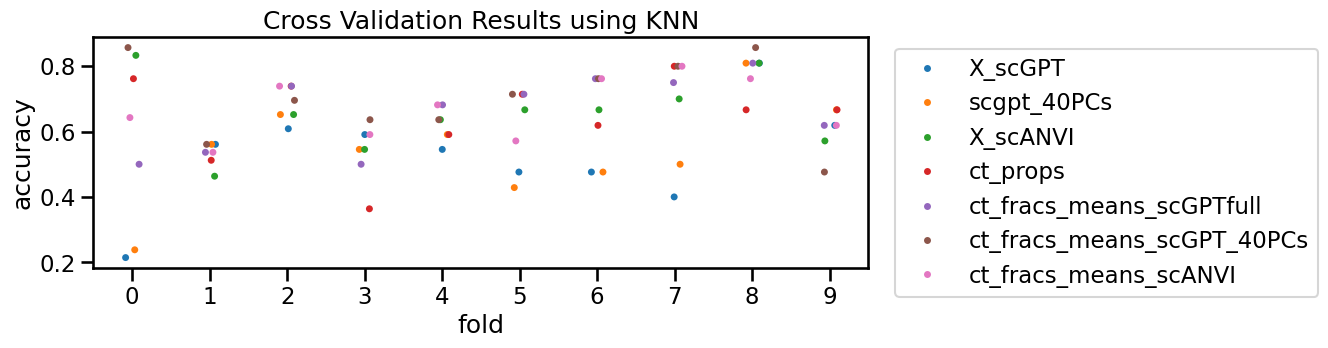

In [162]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust the figure size
plt.figure(figsize=(10, 3))  # Width = 12, Height = 6 (you can change these values as needed)

# Create the stripplot
sns.stripplot(
    data=pd.DataFrame(task2_results_k10['KNN']).reset_index().rename(columns={"index": "fold"}).melt(id_vars="fold"),
    x="fold",
    y="value",
    hue="variable"
)

# Move the legend to the right side outside the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.ylabel("accuracy")
plt.title("Cross Validation Results using KNN")

# Show the plot
plt.show()

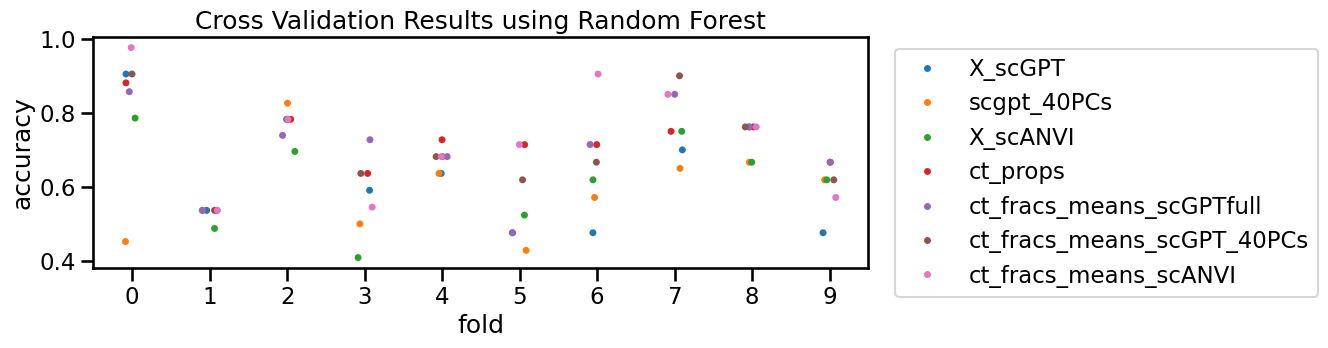

In [163]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust the figure size
plt.figure(figsize=(10, 3))  # Width = 12, Height = 6 (you can change these values as needed)

# Create the stripplot
sns.stripplot(
    data=pd.DataFrame(task2_results_k10['random_forest']).reset_index().rename(columns={"index": "fold"}).melt(id_vars="fold"),
    x="fold",
    y="value",
    hue="variable"
)

# Move the legend to the right side outside the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.ylabel("accuracy")
plt.title("Cross Validation Results using Random Forest")

# Show the plot
plt.show()

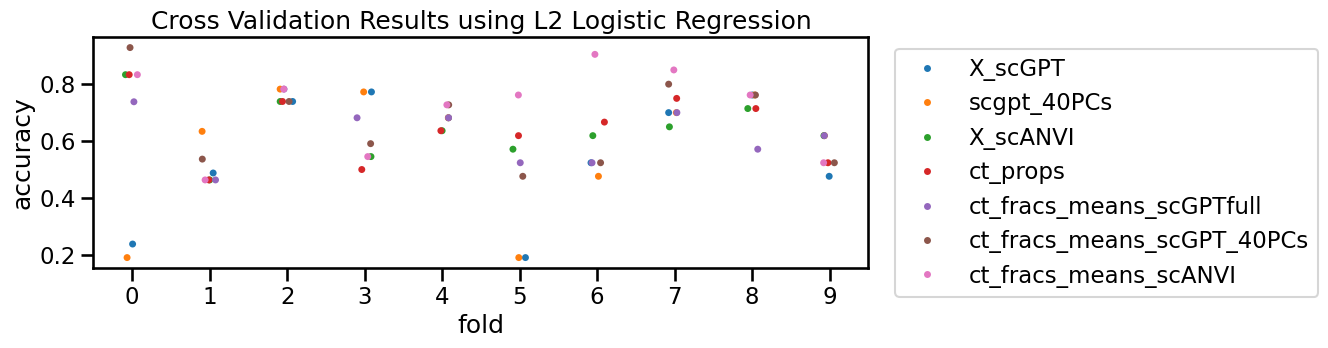

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust the figure size
plt.figure(figsize=(10, 3))  # Width = 12, Height = 6 (you can change these values as needed)

# Create the stripplot
sns.stripplot(
    data=pd.DataFrame(task2_results_k10['logistic_regression']).reset_index().rename(columns={"index": "fold"}).melt(id_vars="fold"),
    x="fold",
    y="value",
    hue="variable"
)

# Move the legend to the right side outside the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.ylabel("accuracy")
plt.title("Cross Validation Results using L2 Logistic Regression")

# Show the plot
plt.show()

## TO DO - significance testing, not most important for getting high level sense of where the signal is

In [132]:
print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(task2_results_k10['KNN']['ct_fracs_means_scGPT_40PCs'], val_majclass_bline_accs)[1],3)))


wilcoxon signed-rank test p-value=0.109


In [ ]:
# check significance of promising results

# need to record per-sample predictions and then FOR SAMPLES where models disagree, can run either binomial or wilcoxon signed-rank test
